In [1]:
import os
import glob
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import torch
from torch.utils.data import Subset
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data import DataLoader, random_split
from torchinfo import summary

In [2]:
DATASET_PATH = os.path.join(os.getcwd(), "throughput_estimator_iq", 'dataset_gnb_10db_(interferer_ue)')
print(DATASET_PATH)
wgn_file_paths = glob.glob(os.path.join(DATASET_PATH, 'df_wgn_*.parquet'))
print(wgn_file_paths)

/opt/nvidia/cuBB/pyaerial/notebooks/throughput_estimator_iq/dataset_gnb_10db_(interferer_ue)
['/opt/nvidia/cuBB/pyaerial/notebooks/throughput_estimator_iq/dataset_gnb_10db_(interferer_ue)/df_wgn_2_de390cac8de345d997e8376a7e36eb5f_20_-12.2.parquet', '/opt/nvidia/cuBB/pyaerial/notebooks/throughput_estimator_iq/dataset_gnb_10db_(interferer_ue)/df_wgn_0_31f73544dae74716ba3af75330d02301_5_-50.0.parquet', '/opt/nvidia/cuBB/pyaerial/notebooks/throughput_estimator_iq/dataset_gnb_10db_(interferer_ue)/df_wgn_3_71cbc372fc174c1ea07389b2d30bd4a7_15_-7.6.parquet', '/opt/nvidia/cuBB/pyaerial/notebooks/throughput_estimator_iq/dataset_gnb_10db_(interferer_ue)/df_wgn_2_de390cac8de345d997e8376a7e36eb5f_3_-22.0.parquet', '/opt/nvidia/cuBB/pyaerial/notebooks/throughput_estimator_iq/dataset_gnb_10db_(interferer_ue)/df_wgn_2_de390cac8de345d997e8376a7e36eb5f_2_-23.0.parquet', '/opt/nvidia/cuBB/pyaerial/notebooks/throughput_estimator_iq/dataset_gnb_10db_(interferer_ue)/df_wgn_2_de390cac8de345d997e8376a7e36eb5f

In [3]:
noise_levels = [float(wgn_file_path.replace('.parquet', '').split('_')[-1]) for wgn_file_path in wgn_file_paths]
noise_levels.sort()
print(noise_levels)

[-100.0, -90.0, -80.0, -70.0, -60.0, -50.0, -40.0, -39.0, -38.0, -37.0, -36.0, -35.0, -34.0, -33.0, -32.0, -31.0, -30.0, -29.0, -28.0, -27.0, -26.0, -25.0, -24.0, -23.0, -22.0, -21.0, -20.0, -19.0, -18.0, -17.0, -16.0, -15.0, -14.0, -13.8, -13.6, -13.4, -13.2, -13.0, -12.8, -12.6, -12.4, -12.2, -12.0, -11.8, -11.6, -11.4, -11.2, -11.0, -10.8, -10.6, -10.4, -10.2, -10.0, -9.8, -9.6, -9.4, -9.2, -9.0, -8.8, -8.6, -8.4, -8.2, -8.0, -7.8, -7.6, -7.4, -7.2]


In [4]:
import heapq
def moving_average(arr, window_size):
    weights = np.ones(window_size) / window_size
    return np.convolve(arr, weights, mode='valid')

def get_throughput(arr):
    W = 10
    mv_avg = moving_average(arr, W)
    largest_numbers = heapq.nlargest(W, mv_avg)
    return sum(largest_numbers) / W

In [48]:
dataset = pd.DataFrame()

for noise_level_idx, noise_level in enumerate(noise_levels):
    if noise_level_idx % 2 == 1:
        continue
    print(f'Noise level: {noise_level}')

    wgn_files = glob.glob(os.path.join(DATASET_PATH, f'df_wgn_*{noise_level}*.parquet'))
    if len(wgn_files) != 1:
        print(f'Found {len(wgn_files)} files for noise level {noise_level}')
        continue
    wgn_file_path = wgn_files[0]
    wgn_df = pd.read_parquet(wgn_file_path)
    # print(wgn_df)
    throughput_mbps = wgn_df['throughput_mbps'].values
    # print(throughput_mbps)
    # plt.plot(throughput_mbps)
    # plt.show()
    throughput = get_throughput(throughput_mbps)
    
    mac_files = glob.glob(os.path.join(DATASET_PATH, f'df_mac_*{noise_level}*.parquet'))
    if len(mac_files) != 1:
        print(f'Found {len(mac_files)} files for noise level {noise_level}')
        continue
    mac_file_path = mac_files[0]
    mac_df = pd.read_parquet(mac_file_path)
    # print(mac_df)

    fapi_files = glob.glob(os.path.join(DATASET_PATH, f'df_fapi_*{noise_level}*.parquet'))
    if len(fapi_files) != 1:
        print(f'Found {len(fapi_files)} files for noise level {noise_level}')
        continue
    fapi_file_path = fapi_files[0]
    fapi_df = pd.read_parquet(fapi_file_path)
    # print(fapi_df)
    
    fh_files = glob.glob(os.path.join(DATASET_PATH, f'df_fh_*{noise_level}*.parquet'))
    if len(fh_files) != 1:
        print(f'Found {len(fh_files)} files for noise level {noise_level}')
        continue
    fh_file_path = fh_files[0]
    fh_df = pd.read_parquet(fh_file_path)
    # print(fh_df)

    for fapi_idx, fapi in fapi_df.iterrows():
        TsTaiNs = fapi.TsTaiNs
        print(f'Sample at {TsTaiNs}')

        matching_mac = mac_df[mac_df['TsTaiNs'] <= TsTaiNs]
        # print(matching_mac)
        if len(matching_mac) < 30:
            continue

        # Sort by TsTaiNs in descending order and get the 10 latest records
        matching_mac = matching_mac.sort_values(by='TsTaiNs', ascending=False).head(30)
        # print(matching_mac)
        matching_mac = matching_mac[['ss_rsrp', 'ss_rsrq', 'ss_sinr', 'ri', 'wb_cqi_1tb', 'cri', 'phr', 'pusch_snr', 'ul_mcs1', 'ul_bler', 'ul_harq_0', 'ul_harq_1', 'ul_harq_2', 'ul_harq_3']].to_numpy()
        # print(matching_mac.shape) # (20, 14)
        # print(matching_mac)
        # Assuming matching_mac is the NumPy array with shape (n_samples, 14)
        # Columns: ['ss_rsrp', 'ss_rsrq', 'ss_sinr', 'ri', 'wb_cqi_1tb', 'cri', 'phr', 
        #           'pusch_snr', 'ul_mcs1', 'ul_bler', 'ul_harq_0', 'ul_harq_1', 'ul_harq_2', 'ul_harq_3']

        # Assuming matching_mac is the NumPy array with shape (n_samples, 14)
        # Columns: ['ss_rsrp', 'ss_rsrq', 'ss_sinr', 'ri', 'wb_cqi_1tb', 'cri', 'phr', 
        #           'pusch_snr', 'ul_mcs1', 'ul_bler', 'ul_harq_0', 'ul_harq_1', 'ul_harq_2', 'ul_harq_3']

        # Step 1: Compute HARQ differences (harq_new - harq_old)
        # harq_new is first row, harq_old is each subsequent row
        harq_indices = [10, 11, 12, 13]  # Indices of ul_harq_0 to ul_harq_3
        modified_matching_mac = matching_mac.copy()  # Avoid modifying original array

        # Compute differences: first row (harq_new) - current row (harq_old)
        for idx in harq_indices:
            modified_matching_mac[:, idx] = matching_mac[0, idx] - matching_mac[:, idx]
            # Handle uint32 wrap-around (if old > new, difference might be negative)
            modified_matching_mac[:, idx] = np.where(
                modified_matching_mac[:, idx] < 0,
                modified_matching_mac[:, idx] + 2**32,
                modified_matching_mac[:, idx]
            )
        # First row's HARQ differences set to 0 (no difference from itself)
        modified_matching_mac[0, harq_indices] = 0

        # Step 2: Define fixed min/max values for normalization
        fixed_max_values = np.array([
            -44,  # ss_rsrp (dBm)
            -3,   # ss_rsrq (dB)
            30,   # ss_sinr (dB)
            4,    # ri
            15,   # wb_cqi_1tb
            7,    # cri
            40,   # phr (dB)
            30,   # pusch_snr (dB)
            31,   # ul_mcs1
            1,    # ul_bler
            1000,  # ul_harq_0 (max difference in retransmissions, adjust as needed)
            1000,  # ul_harq_1
            1000,  # ul_harq_2
            1000   # ul_harq_3
        ])

        fixed_min_values = np.array([
            -140,  # ss_rsrp
            -20,   # ss_rsrq
            -20,   # ss_sinr
            1,     # ri
            0,     # wb_cqi_1tb
            0,     # cri
            -23,   # phr
            -20,   # pusch_snr
            0,     # ul_mcs1
            0,     # ul_bler
            0,     # ul_harq_0 (min difference)
            0,     # ul_harq_1
            0,     # ul_harq_2
            0      # ul_harq_3
        ])

        # Step 3: Min-Max normalization with fixed values
        range_vals = fixed_max_values - fixed_min_values
        range_vals[range_vals == 0] = 1  # Prevent division by zero

        normalized_matching_mac = (modified_matching_mac - fixed_min_values) / range_vals
        # print(normalized_matching_mac)

        matching_fh = fh_df[fh_df['TsTaiNs'] == TsTaiNs]
        # print(len(matching_fh))
        if len(matching_fh) != 1:
            continue
        # print(matching_fh)

        fh_samp = np.array(matching_fh['fhData'].iloc[0], dtype=np.float32)
        rx_slot = np.swapaxes(fh_samp.view(np.complex64).reshape(4, 14, 273*12), 2, 0)[:,:,0]
        # print(rx_slot)
        # print(rx_slot.shape)

        rx_slot[fapi.rbStart: fapi.rbSize * 12, fapi.StartSymbolIndex : 14] = 0
        I = np.real(rx_slot)  # Real part
        Q = np.imag(rx_slot)  # Imaginary part
        IQ_tensor = np.stack([I, Q], axis=0)
        # print(IQ_tensor.shape) # (2, 3276, 14)

        # # fig, axs = plt.subplots(1)
        # # axs.imshow(10*np.log10(np.abs(rx_slot**2)), aspect='auto')
        # # axs.set_ylim([0, 273 * 12])
        # # axs.set_xlim([0, 14])
        # # axs.set_title('Ant ' + str(0))
        # # axs.set(xlabel='Symbol', ylabel='Resource Element')
        # # axs.label_outer()
        # # fig.suptitle('Power in RU Antennas') 
        # # plt.show(fig)
        new_row = pd.DataFrame({
            'throughput_mbps': [throughput],
            'mac': [matching_mac],
            'fapi': [[fapi.rbStart/273, fapi.rbSize/273, fapi.StartSymbolIndex/14, 14/14]],
            'iq': [IQ_tensor],
        })
        dataset = pd.concat([dataset, new_row], ignore_index=True)
    #     break  
    # break


Noise level: -100.0
Sample at 2025-04-14 06:28:13.062000
Sample at 2025-04-14 06:28:14.002000
Sample at 2025-04-14 06:28:15.052000
Sample at 2025-04-14 06:28:16.042000
Sample at 2025-04-14 06:28:17.062000
Sample at 2025-04-14 06:28:18.022000
Sample at 2025-04-14 06:28:19.082000
Sample at 2025-04-14 06:28:20.022000
Sample at 2025-04-14 06:28:21.092000
Sample at 2025-04-14 06:28:22.082000
Sample at 2025-04-14 06:28:23.142000
Sample at 2025-04-14 06:28:24.002000
Sample at 2025-04-14 06:28:25.022000
Sample at 2025-04-14 06:28:26.042000
Sample at 2025-04-14 06:28:27.062000
Sample at 2025-04-14 06:28:28.012000
Sample at 2025-04-14 06:28:29.002000
Sample at 2025-04-14 06:28:30.022000
Sample at 2025-04-14 06:28:31.042000
Sample at 2025-04-14 06:28:32.062000
Sample at 2025-04-14 06:28:33.062000
Sample at 2025-04-14 06:28:34.032000
Sample at 2025-04-14 06:28:35.122000
Sample at 2025-04-14 06:28:36.042000
Sample at 2025-04-14 06:28:37.062000
Sample at 2025-04-14 06:28:38.082000
Sample at 2025-04-

In [49]:
print(dataset)
# rbsize_s = np.stack(dataset['fapi'].to_numpy())[:, 1]
# print([rbsize if rbsize > 0.5 else 0 for rbsize in rbsize_s])
# print(np.stack(dataset['fapi'].to_numpy())[:, 1])
# plt.plot(np.stack(dataset['fapi'].to_numpy())[:, 1])
# plt.show()

       throughput_mbps                                                mac  \
0            53.673190  [[-78.0, -10.5, 23.5, 2.0, 15.0, 0.0, 48.0, 23...   
1            53.673190  [[-78.0, -10.5, 23.5, 2.0, 15.0, 0.0, 48.0, 22...   
2            53.673190  [[-78.0, -10.5, 23.5, 2.0, 15.0, 0.0, 48.0, 22...   
3            53.673190  [[-78.0, -10.5, 23.5, 2.0, 15.0, 0.0, 48.0, 22...   
4            53.673190  [[-78.0, -10.5, 23.5, 2.0, 15.0, 0.0, 48.0, 21...   
...                ...                                                ...   
14608         0.892886  [[-79.0, -10.5, 23.5, 1.0, 0.0, 0.0, 48.0, 23....   
14609         0.892886  [[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 31.0, 0.0...   
14610         0.892886  [[-78.0, -10.5, 23.5, 1.0, 15.0, 0.0, 48.0, 23...   
14611         0.892886  [[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 21.0, 0.0...   
14612         0.892886  [[-78.0, -10.5, 23.5, 1.0, 0.0, 0.0, 48.0, 26....   

                                        fapi  \
0      [0.0, 0.018315018315

In [50]:
print(dataset.shape)

X_mac_torch = torch.tensor(np.stack(dataset['mac'].to_numpy()), dtype=torch.float32)
print(f'X_mac_torch.shape: {X_mac_torch.shape}')
X_fapi_torch = torch.tensor(np.stack(dataset['fapi'].to_numpy()), dtype=torch.float32)
print(f'X_fapi_torch.shape: {X_fapi_torch.shape}')
X_iq_torch = torch.tensor(np.stack(dataset['iq'].to_numpy()), dtype=torch.float32)
print(f'X_iq_torch.shape: {X_iq_torch.shape}')
y_torch = torch.tensor(dataset['throughput_mbps'].to_numpy(), dtype=torch.float32)
print(f'y_torch.shape: {y_torch.shape}')

(14613, 4)
X_mac_torch.shape: torch.Size([14613, 30, 14])
X_fapi_torch.shape: torch.Size([14613, 4])
X_iq_torch.shape: torch.Size([14613, 2, 3276, 14])
y_torch.shape: torch.Size([14613])


In [51]:
print(dataset['throughput_mbps'].to_numpy())

[53.67318971 53.67318971 53.67318971 ...  0.89288625  0.89288625
  0.89288625]


In [9]:
import torch
import torch.nn as nn

class ThroughputEstimator(nn.Module):
    def __init__(self, lstm_input_size, output_size, hidden_size, num_layers, model_type, drop_out=0.1):
        super().__init__()

        self.lstm_input_size = lstm_input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        self.drop_out = drop_out
        self.model_type = model_type

        if self.model_type == 1 or self.model_type == 3:
            self.lstm = nn.LSTM(
                input_size=self.lstm_input_size,
                hidden_size=self.hidden_size,
                num_layers=self.num_layers,
                batch_first=True,
                dropout=self.drop_out if self.num_layers > 1 else 0.0,
            )

        if self.model_type == 2 or self.model_type == 3:
            self.cnn = nn.Sequential(
                nn.Conv2d(2, 16, kernel_size=3, stride=1, padding=1),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Flatten(),
                nn.Linear(32 * 819 * 3, self.hidden_size),  # Verify dimensions
                nn.ReLU(),
                nn.Dropout(self.drop_out)
            )

        # Unified FC layer for all model types
        self.fc = nn.Sequential(
            nn.Linear(self.hidden_size, self.output_size),
            nn.Dropout(self.drop_out) if self.drop_out > 0 else nn.Identity()
        )

    def forward(self, lstm_input, fapi, cnn_input):
        w = None
        if self.model_type == 1 or self.model_type == 3:
            h0 = torch.zeros(self.num_layers, lstm_input.size(0), self.hidden_size).to(lstm_input.device)
            c0 = torch.zeros(self.num_layers, lstm_input.size(0), self.hidden_size).to(lstm_input.device)
            lstm_out, _ = self.lstm(lstm_input, (h0, c0))
            lstm_out = lstm_out[:, -1, :]

        if self.model_type == 2 or self.model_type == 3:
            cnn_out = self.cnn(cnn_input)

        if self.model_type == 1:
            out = self.fc(lstm_out)
        elif self.model_type == 2:
            out = self.fc(cnn_out)
        elif self.model_type == 3:
            w = (fapi[:, 1] * fapi[:, 3]).unsqueeze(-1)
            combined = w * lstm_out + (1 - w) * cnn_out
            out = self.fc(combined)

        return out.squeeze(-1) if self.output_size == 1 else out, w

In [10]:
import dill
import torch

lstm_only_model = ThroughputEstimator(14, 1, 50, 1, 1)
cnn_only_model = ThroughputEstimator(14, 1, 50, 1, 2)
combined_model = ThroughputEstimator(14, 1, 50, 1, 3)
model_stats = summary(lstm_only_model)
print(model_stats)
model_stats = summary(cnn_only_model)
print(model_stats)
model_stats = summary(combined_model)
print(model_stats)

Layer (type:depth-idx)                   Param #
ThroughputEstimator                      --
├─LSTM: 1-1                              13,200
├─Sequential: 1-2                        --
│    └─Linear: 2-1                       51
│    └─Dropout: 2-2                      --
Total params: 13,251
Trainable params: 13,251
Non-trainable params: 0
Layer (type:depth-idx)                   Param #
ThroughputEstimator                      --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       304
│    └─ReLU: 2-2                         --
│    └─MaxPool2d: 2-3                    --
│    └─Conv2d: 2-4                       4,640
│    └─ReLU: 2-5                         --
│    └─MaxPool2d: 2-6                    --
│    └─Flatten: 2-7                      --
│    └─Linear: 2-8                       3,931,250
│    └─ReLU: 2-9                         --
│    └─Dropout: 2-10                     --
├─Sequential: 1-2                        --
│    └─Linear: 2-11      

In [11]:
# Check for GPU availability
print(f"Number of GPUs available: {torch.cuda.device_count()}")

# Set device dynamically
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Assuming models are defined, move them to the device
try:
    lstm_only_model.to(device)
    cnn_only_model.to(device)
    combined_model.to(device)
    print("Models moved to device successfully.")
except NameError as e:
    print(f"Error: One or more models are not defined - {e}")
# model.train(True)

def check_model_device(model, model_name):
    for name, param in model.named_parameters():
        print(f"{model_name} parameter '{name}' is on device: {param.device}")

check_model_device(lstm_only_model, "lstm_only_model")
check_model_device(cnn_only_model, "cnn_only_model")
check_model_device(combined_model, "combined_model")

Number of GPUs available: 1
Using device: cuda:0
Models moved to device successfully.
lstm_only_model parameter 'lstm.weight_ih_l0' is on device: cuda:0
lstm_only_model parameter 'lstm.weight_hh_l0' is on device: cuda:0
lstm_only_model parameter 'lstm.bias_ih_l0' is on device: cuda:0
lstm_only_model parameter 'lstm.bias_hh_l0' is on device: cuda:0
lstm_only_model parameter 'fc.0.weight' is on device: cuda:0
lstm_only_model parameter 'fc.0.bias' is on device: cuda:0
cnn_only_model parameter 'cnn.0.weight' is on device: cuda:0
cnn_only_model parameter 'cnn.0.bias' is on device: cuda:0
cnn_only_model parameter 'cnn.3.weight' is on device: cuda:0
cnn_only_model parameter 'cnn.3.bias' is on device: cuda:0
cnn_only_model parameter 'cnn.7.weight' is on device: cuda:0
cnn_only_model parameter 'cnn.7.bias' is on device: cuda:0
cnn_only_model parameter 'fc.0.weight' is on device: cuda:0
cnn_only_model parameter 'fc.0.bias' is on device: cuda:0
combined_model parameter 'lstm.weight_ih_l0' is on d

In [52]:
import torch
from torch.utils.data import TensorDataset, Subset, DataLoader

# Set fixed seed for reproducibility
seed = 42
torch.manual_seed(seed)

# Create TensorDataset
tdataset = TensorDataset(X_mac_torch, X_fapi_torch, X_iq_torch, y_torch)

# Size setup
dataset_size = len(tdataset)
train_size = int(0.8 * dataset_size)
test_size = dataset_size - train_size

# Generate a random permutation of indices
indices = torch.randperm(dataset_size).tolist()

# Split indices into train and test
train_indices = sorted(indices[:train_size])  # Take first train_size indices and sort
test_indices = sorted(indices[train_size:])   # Take remaining indices and sort

# Create Subsets
train_dataset = Subset(tdataset, train_indices)
test_dataset = Subset(tdataset, test_indices)

In [67]:
# Create DataLoaders
train_data = DataLoader(
    train_dataset,
    batch_size=2**2,  # 1024
    shuffle=True,      # Shuffle training data each epoch
    drop_last=False
)
preloaded_train_data = list(train_data)

RuntimeError: stack expects each tensor to be equal size, but got [5000, 2, 3276, 14] at entry 0 and [5000, 4] at entry 1

In [54]:
test_data = DataLoader(
    test_dataset,
    batch_size=1,  # 1024
    shuffle=False,     # No shuffling for evaluation
    drop_last=False
)
preloaded_test_data = list(test_data)

In [15]:
lstm_criterion = nn.MSELoss()
lstm_optimizer = torch.optim.Adam(lstm_only_model.parameters(), lr=0.001, weight_decay=0.005)

# Training loop
num_epochs = 1000

lstm_only_model.train()

for epoch in range(num_epochs):
    lstm_train_loss = 0

    for i, (batch_mac, batch_iq, batch_y) in enumerate(preloaded_train_data):
        batch_mac = batch_mac.to(device)
        batch_y = batch_y.to(device)

        # Forward pass
        lstm_outputs = lstm_only_model(batch_mac, None)
        lstm_loss = lstm_criterion(lstm_outputs, batch_y)
        # Backward pass
        lstm_optimizer.zero_grad()
        lstm_loss.backward()
        lstm_optimizer.step()
        lstm_train_loss += lstm_loss.item() * batch_y.size(0)

    lstm_train_loss = lstm_train_loss / len(train_dataset)
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], lstm_train_loss: {lstm_train_loss:.4f}')

ValueError: too many values to unpack (expected 3)

In [ ]:
cnn_criterion = nn.MSELoss()
cnn_optimizer = torch.optim.Adam(cnn_only_model.parameters(), lr=0.0001, weight_decay=0.0005)

# Training loop
num_epochs = 10

cnn_only_model.train()

for epoch in range(num_epochs):
    print(f'Begin of epoch {epoch}')
    cnn_train_loss = 0

    for i, (batch_mac, batch_iq, batch_y) in enumerate(preloaded_train_data):
        print(f'Start of batch {i}')
        batch_iq = batch_iq.to(device)
        batch_y = batch_y.to(device)

        # Forward pass
        cnn_outputs = cnn_only_model(None, batch_iq)
        cnn_loss = cnn_criterion(cnn_outputs, batch_y)
        # Backward pass
        cnn_optimizer.zero_grad()
        cnn_loss.backward()
        cnn_optimizer.step()
        cnn_train_loss += cnn_loss.item() * batch_y.size(0)

    cnn_train_loss = cnn_train_loss / len(train_dataset)
    print(f'Epoch [{epoch + 1}/{num_epochs}], cnn_train_loss: {cnn_train_loss:.4f}')

In [ ]:
# combined_criterion = nn.MSELoss()
criterion = nn.CrossEntropyLoss(reduction='none')
combined_optimizer = torch.optim.Adam(combined_model.parameters(), lr=0.000001, weight_decay=0.000005)

# Training loop
num_epochs = 100

combined_model.train()

for epoch in range(num_epochs):
    # print(f'Begin of epoch {epoch}')
    combined_train_loss = 0

    for i, (batch_mac, batch_fapi, batch_iq, batch_y) in enumerate(preloaded_train_data):
        # print(f'Start of batch {i}')
        # magnitude = ((batch_fapi[:, 1] - batch_fapi[:, 0])**2 + (batch_fapi[:, 2] - batch_fapi[:, 1])**2).cpu().numpy()
        # print(f"Batch fapi magnitudes: {magnitude}")
    
        batch_mac = batch_mac.to(device)
        batch_fapi = batch_fapi.to(device)
        batch_iq = batch_iq.to(device)
        batch_y = batch_y.to(device)

        # print('batch_fapi', batch_fapi)
        # Forward pass
        combined_outputs, w = combined_model(batch_mac, batch_fapi, batch_iq)
        # print(f'w: {w}')
        combined_loss = combined_criterion(combined_outputs, batch_y)
        # penalty = 100* torch.mean(abs(w - batch_fapi[:, 1] * batch_fapi[:, 3]))
        # print(f'penalty: {penalty}')    
        # combined_loss += penalty
        
        # Backward pass
        combined_optimizer.zero_grad()
        combined_loss.backward()
        combined_optimizer.step()
        combined_train_loss += combined_loss.item() * batch_y.size(0)
        # print(f'End of batch {i}')

    combined_train_loss = combined_train_loss / len(train_dataset)
    print(f'Epoch [{epoch + 1}/{num_epochs}], combined_train_loss: {combined_train_loss:.4f}')

tensor(1., device='cuda:0', grad_fn=<DivBackward0>)


TypeError: len() of a 0-d tensor

---
batch_fapi: tensor([[0.0000, 0.0183, 0.0000, 1.0000]], device='cuda:0')
w: tensor([[0.0183]], device='cuda:0')
---
batch_fapi: tensor([[0.0000, 0.0183, 0.0000, 1.0000]], device='cuda:0')
w: tensor([[0.0183]], device='cuda:0')
---
batch_fapi: tensor([[0.0000, 0.0183, 0.0000, 1.0000]], device='cuda:0')
w: tensor([[0.0183]], device='cuda:0')
---
batch_fapi: tensor([[0.0000, 0.0183, 0.0000, 1.0000]], device='cuda:0')
w: tensor([[0.0183]], device='cuda:0')
---
batch_fapi: tensor([[0.0000, 0.0183, 0.0000, 1.0000]], device='cuda:0')
w: tensor([[0.0183]], device='cuda:0')
---
batch_fapi: tensor([[0.0000, 0.0183, 0.0000, 1.0000]], device='cuda:0')
w: tensor([[0.0183]], device='cuda:0')
---
batch_fapi: tensor([[0.0000, 0.0183, 0.0000, 1.0000]], device='cuda:0')
w: tensor([[0.0183]], device='cuda:0')
---
batch_fapi: tensor([[0.0000, 0.0183, 0.0000, 1.0000]], device='cuda:0')
w: tensor([[0.0183]], device='cuda:0')
---
batch_fapi: tensor([[0.0000, 0.0183, 0.0000, 1.0000]], device='cuda:0')
w: t

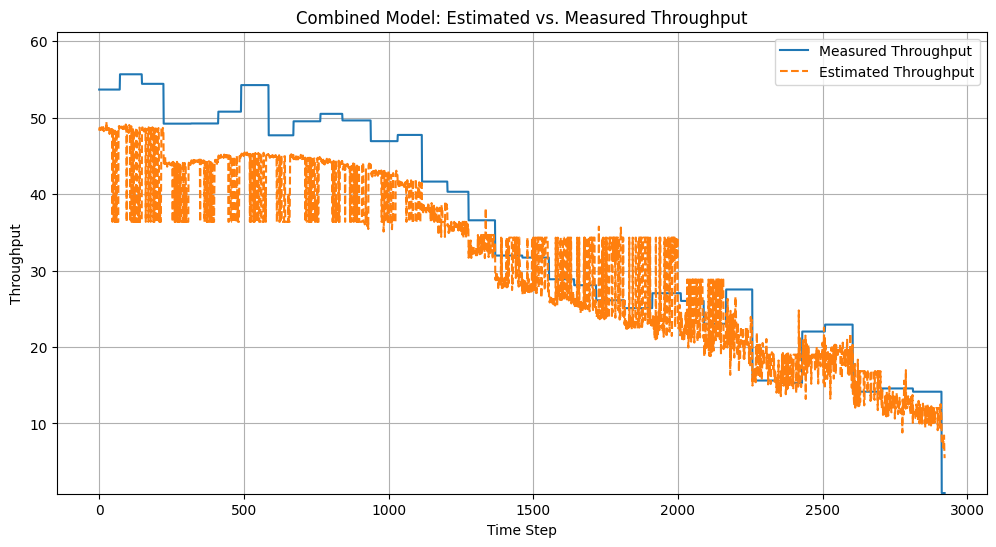

Summary of Metrics:
LSTM Only:
  R²: 0.0000, MAE: 0.0000, MSE: 0.0000
CNN Only:
  R²: 0.0000, MAE: 0.0000, MSE: 0.0000
Combined:
  R²: 0.7815, MAE: 5.3631, MSE: 43.1301


In [66]:
import numpy as np
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# List of models to evaluate
models = {
    # 'LSTM Only': lstm_only_model,
    # 'CNN Only': cnn_only_model,
    'Combined': combined_model,
}

# Dictionary to store metrics for each model
metrics = {
    'LSTM Only': {'r2': 0, 'mae': 0, 'mse': 0},
    'CNN Only': {'r2': 0, 'mae': 0, 'mse': 0},
    'Combined': {'r2': 0, 'mae': 0, 'mse': 0}
}

# Evaluate each model
for model_name, model in models.items():
    model.eval()
    y, p = [], []  # Lists to store ground truth and predictions

    with torch.no_grad():  # Disable gradient computation
        for i, (batch_mac, batch_fapi, batch_iq, batch_y) in enumerate(preloaded_test_data):
            # Move to device
            batch_mac = batch_mac.to(device)
            batch_iq = batch_iq.to(device)
            batch_fapi = batch_fapi.to(device)
            batch_y = batch_y.to(device)
            print("---")
            print(f'batch_fapi: {batch_fapi}')

            # Forward pass
            if model_name == 'LSTM Only':
                outputs = model(batch_mac, None, None)  # LSTM uses batch_mac only
            elif model_name == 'CNN Only':
                outputs = model(None, None, batch_iq)  # CNN uses batch_iq only
            else:  # Combined model
                outputs, w = model(batch_mac, batch_fapi, batch_iq)
                print(f'w: {w}')

            predicted = outputs.cpu().numpy().squeeze()  # Handle shape
            targets = batch_y.cpu().numpy().squeeze()

            # Collect data
            y.append(targets)
            p.append(predicted)

    # Convert to arrays
    y = np.array(y)
    p = np.array(p)

    # Verify lengths
    assert len(y) == len(p), f"Length mismatch for {model_name}: y={len(y)}, p={len(p)}"
    print(f"{model_name} - Test set size: {len(y)} samples")

    # Compute metrics
    r2 = r2_score(y, p)
    mae = mean_absolute_error(y, p)
    mse = mean_squared_error(y, p)
    
    # Store metrics
    metrics[model_name]['r2'] = r2
    metrics[model_name]['mae'] = mae
    metrics[model_name]['mse'] = mse

    print(f"{model_name} Metrics:")
    print(f"  R² Score: {r2:.4f}")
    print(f"  MAE: {mae:.4f}")
    print(f"  MSE: {mse:.4f}\n")

    # Subsample for plotting
    step = 1  # Adjusted for more detail
    y_sub = y[::step]
    p_sub = p[::step]
    # end = 100  # Adjusted for more detail
    # y_sub = y[:end]
    # p_sub = p[:end]
    
    time_steps = np.arange(len(y_sub))

    # Plotting
    plt.figure(figsize=(12, 6))
    plt.plot(time_steps, y_sub, label='Measured Throughput')
    plt.plot(time_steps, p_sub, label='Estimated Throughput', linestyle='--')
    plt.title(f'{model_name} Model: Estimated vs. Measured Throughput')
    plt.xlabel('Time Step')
    plt.ylabel('Throughput')
    # Dynamic y-axis limits with 10% padding
    y_min = min(np.min(y_sub), np.min(p_sub))
    y_max = max(np.max(y_sub), np.max(p_sub))
    plt.ylim(y_min * 1.1 if y_min < 0 else y_min * 0.9, y_max * 1.1)
    plt.legend()
    plt.grid(True)
    plt.show()

# Print summary of metrics
print("Summary of Metrics:")
for model_name, metric in metrics.items():
    print(f"{model_name}:")
    print(f"  R²: {metric['r2']:.4f}, MAE: {metric['mae']:.4f}, MSE: {metric['mse']:.4f}")

In [60]:
torch.save(lstm_only_model, os.path.join(DATASET_PATH, "lstm_only_model.pth"), pickle_module=dill)
torch.save(cnn_only_model,  os.path.join(DATASET_PATH, "cnn_only_model.pth"), pickle_module=dill)
torch.save(combined_model,  os.path.join(DATASET_PATH, "combined_model.pth"), pickle_module=dill)

In [ ]:
x_macs = np.stack(dataset['mac'].to_numpy())
x_fapis = np.stack(dataset['fapi'].to_numpy())
x_iqs = np.stack(dataset['iq'].to_numpy())
ys = np.stack(dataset['throughput_mbps'].to_numpy())
print(x_macs.shape)
print(x_iqs.shape)
print(ys.shape)


In [ ]:
INDEXs = [2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 11000]

for INDEX in INDEXs:
    x_mac = x_macs[INDEX]
    x_fapi = x_fapis[INDEX]
    x_iq = x_iqs[INDEX]
    y = ys[INDEX]
    print(x_mac.shape)
    print(x_fapi)
    print(x_iq.shape)
    print(y)

    batch_x_mac = torch.tensor(np.array([x_mac]), dtype=torch.float32)
    batch_x_fapi = torch.tensor(np.array([x_fapi]), dtype=torch.float32)
    batch_x_iq = torch.tensor(np.array([x_iq]), dtype=torch.float32)
    
    batch_x_mac_device = batch_x_mac.to(device)
    batch_x_fapi_device = batch_x_fapi.to(device)
    batch_x_iq_device = batch_x_iq.to(device)
    
    with torch.no_grad():
        outputs = combined_model(batch_x_mac_device, batch_x_fapi_device, batch_x_iq_device)  # LSTM uses batch_mac only
    predicted = outputs.cpu().numpy().squeeze()
    print(predicted)

    # Compute RMS across the two channels
    # RMS = sqrt(mean(x^2)) over the channel axis (axis 0)
    rms_array = np.sqrt(np.mean(x_iq ** 2, axis=0))  # Shape: (3276, 14)
    # Plot the RMS array as an image
    # plt.figure(figsize=(5, 20))  # Tall and narrow figure for 3276x14
    plt.imshow(10*np.log10(rms_array), aspect='auto')
    plt.title('RMS of Two Channels')
    plt.xlabel('Width')
    plt.ylabel('Height')
    plt.colorbar(label='RMS Value')
    plt.axis('on')
    plt.tight_layout()
    plt.show()
